In [1]:
import pandas as pd
import numpy as np
import os
import glob

import PIL
from PIL import Image
import imageio

import tensorflow as tf
import tensorflow_datasets as tfds

from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt

import seaborn as sn
import numpy as np
import pathlib

In [2]:
train_dir = pathlib.Path('../input/brain-image-clean/train')
test_dir = pathlib.Path('../input/brain-image-clean/test')

image_count_train = len(list(train_dir.glob('*/*.jpg')))
image_count_test = len(list(test_dir.glob('*/*.jpg')))
print("Train Image Count: {} \n Test Image Count: {}".format(image_count_train,image_count_test))

Train Image Count: 2100 
 Test Image Count: 900


## Create DataSet

In [3]:
batch_size = 32
img_height = 180
img_width = 180

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=None,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2100 files belonging to 2 classes.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 900 files belonging to 2 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)

['no', 'yes']


In [7]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Building

In [9]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(255, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

hist = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=8
)

Epoch 1/8
66/66 [==============================] - 56s 824ms/step - loss: 0.5500 - accuracy: 0.7072 - val_loss: 0.3381 - val_accuracy: 0.8278
Epoch 2/8
66/66 [==============================] - 49s 749ms/step - loss: 0.2257 - accuracy: 0.9104 - val_loss: 0.2533 - val_accuracy: 0.8900
Epoch 3/8
66/66 [==============================] - 50s 754ms/step - loss: 0.1475 - accuracy: 0.9524 - val_loss: 0.2437 - val_accuracy: 0.8989
Epoch 4/8
66/66 [==============================] - 49s 736ms/step - loss: 0.1038 - accuracy: 0.9660 - val_loss: 0.1277 - val_accuracy: 0.9500
Epoch 5/8
66/66 [==============================] - 49s 744ms/step - loss: 0.0589 - accuracy: 0.9815 - val_loss: 0.0953 - val_accuracy: 0.9756
Epoch 6/8
66/66 [==============================] - 48s 735ms/step - loss: 0.0382 - accuracy: 0.9891 - val_loss: 0.0966 - val_accuracy: 0.9767
Epoch 7/8
66/66 [==============================] - 49s 744ms/step - loss: 0.0210 - accuracy: 0.9967 - val_loss: 0.1191 - val_accuracy: 0.9733
Epoch 

## Model Summary

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 32)        0

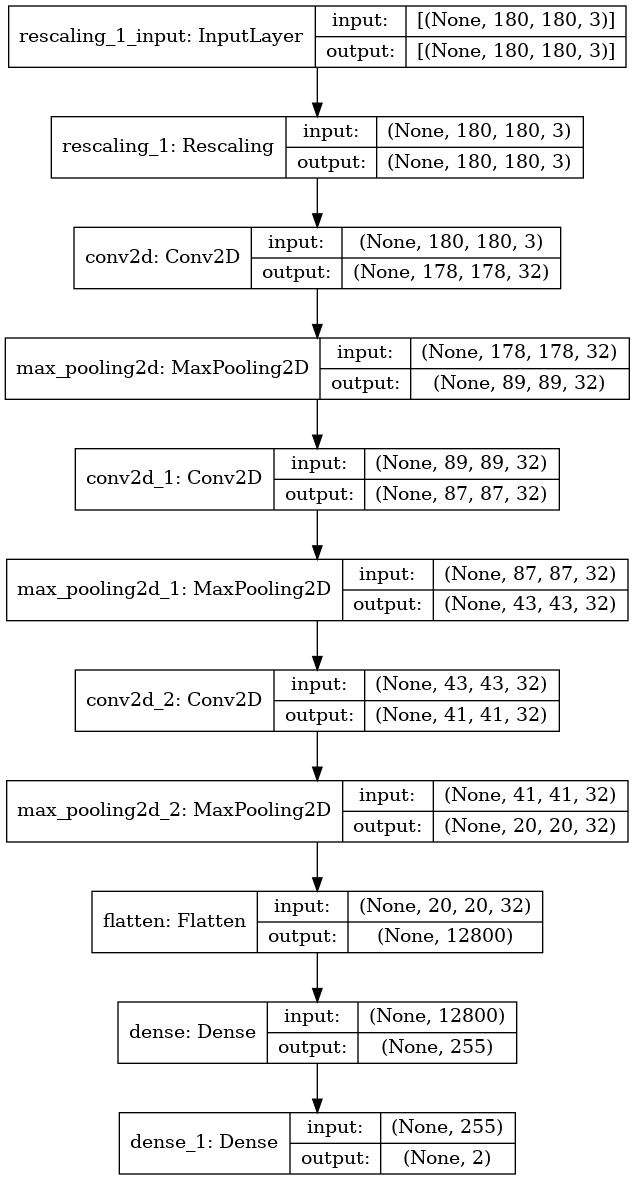

In [11]:
tf.keras.utils.plot_model(model,
                          show_shapes=True,
                          expand_nested=True)

## Fit, Evaluate Model

### Visualize Results

In [12]:
def plot_metrics(history):
  metrics = ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    try:
      name = metric.replace("_"," ").capitalize()
      plt.plot(history.epoch, history.history[metric], label='Train')
      plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
      plt.xlabel('Epoch')
      plt.ylabel(name)
      if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
      elif metric == 'auc':
        plt.ylim([0.8,1])
      else:
        plt.ylim([0,1])
      plt.legend()
      plt.show()  
    except:
      pass

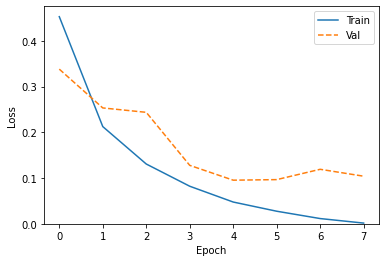

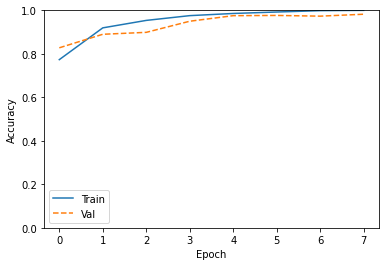

In [13]:
plot_metrics(hist)

# Model Testing on Test Data

In [14]:
def list_files(dir,full_dir):
    r = []
    r1 = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            rr = os.path.join(root, name)
            r.append(rr)
    dd = {'local_path':r}
    df = pd.DataFrame(dd)
    return df

def proccess(img1):
  img = tf.keras.preprocessing.image.load_img(
      img1, target_size=(img_height, img_width)
  )
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  pred = class_names[np.argmax(score)]
  score1 = 100 * np.max(score)

  return pred, score1

def new_col(col):
    if col['Pred'] == 'yes' and col['Actual'] == 'yes':
        return 1
    elif col['Pred'] == 'no' and col['Actual'] == 'no':
      return 1
    else:
      return 0


def proccess1(df):
  aa = []
  bb = []
  cc = []

  for a,b in df.iterrows():
    img = b['local_path']
    pred, value = proccess(img)
    pat = b['local_path']
    
    val = pat.split('/')[4]
    
    aa.append(pred)
    bb.append(value)
    cc.append(val)
  vals = {"Pred":aa,"Accurarcy":bb,'Actual':cc}
  df_test1 = pd.DataFrame(vals)
  df_test1 = pd.concat([df,df_test1], axis=1)

  df_test1['Check'] = df_test1.apply(lambda col: new_col (col),axis=1)

  return df_test1


In [15]:
fullpath = '../input/brain-image-clean/test/'
path = "test"

df_test = list_files(fullpath, path)
df_test1 = proccess1(df_test)

In [16]:
def new_col(col):
    if col['Pred'] == 'yes':
        return 1
    else:
      return 0
def new_col2(col):
    if col['Actual'] == 'yes':
        return 1
    else:
      return 0
df_test1['Pred1'] = df_test1.apply(lambda col: new_col (col),axis=1)
df_test1['Actual1'] = df_test1.apply(lambda col: new_col2 (col),axis=1)
df_test1.head()

,local_path,Pred,Accurarcy,Actual,Check,Pred1,Actual1
0,../input/brain-image-clean/test/no/no26.jpg,no,99.560839,no,1,0,0
1,../input/brain-image-clean/test/no/no979.jpg,no,99.999988,no,1,0,0
2,../input/brain-image-clean/test/no/no715.jpg,no,99.983311,no,1,0,0
3,../input/brain-image-clean/test/no/no122.jpg,no,100.000000,no,1,0,0
4,../input/brain-image-clean/test/no/no457.jpg,yes,94.636738,no,0,1,0


In [17]:
df_test1.head()

,local_path,Pred,Accurarcy,Actual,Check,Pred1,Actual1
0,../input/brain-image-clean/test/no/no26.jpg,no,99.560839,no,1,0,0
1,../input/brain-image-clean/test/no/no979.jpg,no,99.999988,no,1,0,0
2,../input/brain-image-clean/test/no/no715.jpg,no,99.983311,no,1,0,0
3,../input/brain-image-clean/test/no/no122.jpg,no,100.000000,no,1,0,0
4,../input/brain-image-clean/test/no/no457.jpg,yes,94.636738,no,0,1,0


## Accurarcy

### Test Accurarcy

In [18]:
form = df_test1.Check.value_counts()[1] / df_test1.Check.count()
print('Accuracy is : {}'.format(form))

Accuracy is : 0.9788888888888889


### Confusion Matrix

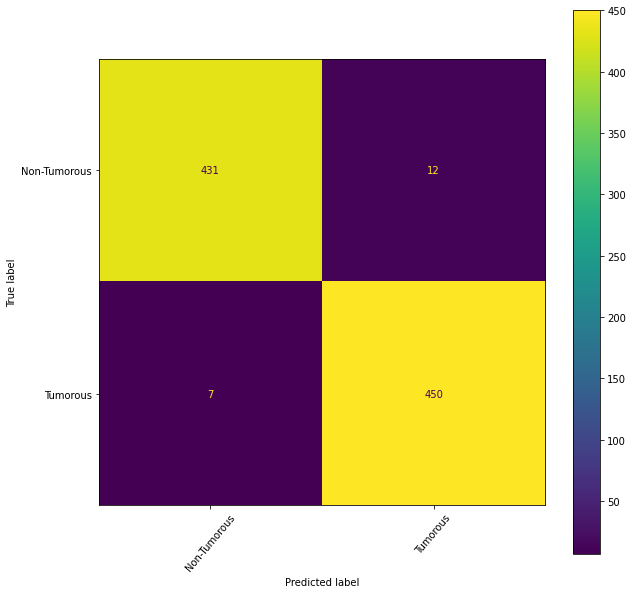

In [19]:
cm = tf.math.confusion_matrix(labels=df_test1['Actual1'].to_numpy(), predictions=df_test1['Pred1'].to_numpy()).numpy()
ls = ['Non-Tumorous', 'Tumorous'] # your y labels()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ls)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(xticks_rotation=50, ax = ax)
plt.show()